# Muultiwavelength HDF5 input
Added by Shooby: Oct 24th

In [3]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image
import h5py


def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def brightest_center(im, r = 10):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans

imdir = '/Users/shemmati/Desktop/GOODS/'

In [5]:
# selecting sample based on brightness, distance and size
gs = pyfits.getdata('/Users/shemmati/Dropbox/WFIRST_WPS/CANDELS_fits/gds.fits')
sel1 = (gs['zbest']>0.01)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=30)
redshifts,ra1,dec1 = (gs['zbest'][sel1]),(gs['RA_1'][sel1]),(gs['DEC_1'][sel1])

print (len(gs[sel1]))

sample_size = len(gs[sel1])
image_size = 28
cut_size = 14

6037


In [8]:
sel = (gs['zbest']>0.01)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=50)

sample_size = len(gs[sel])
image_size = 64
cut_size = 32
ra1,dec1,red1 = gs['RA_1'][sel1],gs['DEC_1'][sel1],gs['zbest'][sel1]
mass1,sfr1 = gs['M_neb_med_lin'][sel1], gs['SFR_13a_tau'][sel1]
urest1,vrest1,jrest1 = gs['restUXbessel'][sel1],gs['restVbessel'][sel1],gs['restJpalomar'][sel1]

# furthur cut on brightest galaxy being at the center of the cutout
redshift,ra,dec,mass,sfr,urest,vrest,jrest = [],[],[],[],[],[],[],[]
for i in range(sample_size):
    dat = cut(ra1[i],dec1[i],cut_size,imdir+'goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    if (brightest_center(dat)):
        redshift.append(red1[i])
        ra.append(ra1[i])
        dec.append(dec1[i])
        mass.append(mass1[i])
        sfr.append(sfr1[i])
        urest.append(urest1[i])
        vrest.append(vrest1[i])
        jrest.append(jrest1[i])

sample_size = len(redshift)
print (sample_size)

3841


In [10]:
#%rm 'Sample.hdf5'
import torchvision.transforms as transforms
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_shape = (sample_size, 7, 64, 64)

hdf5_file = h5py.File('Sample.hdf5', mode='w')

hdf5_file.create_dataset("train_img", train_shape, np.float32)
hdf5_file.create_dataset("train_labels", (sample_size,), np.float32)
hdf5_file["train_labels"][...] = redshift

for i in range(sample_size):
    # print how many images are saved every 1000 images
    if i % 500 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, len(gs[sel1])))

        
    data = np.zeros((7,64,64))
    pashe = np.zeros((7,64,64))
    
    data[0,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
    data[1,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    data[2,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
    data[3,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    data[4,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    data[5,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f125w_060mas_v1.0_drz.fits')
    data[6,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')

    for chi in range(7):
        s = ndimage.rotate(data[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pash = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        pashe[chi,:,:] = tfms(pash)

    # save the image and calculate the mean so far
    hdf5_file["train_img"][i, ...] = pashe

hdf5_file.close()

Train data: 500/4807
Train data: 1000/4807
Train data: 1500/4807
Train data: 2000/4807
Train data: 2500/4807
Train data: 3000/4807
Train data: 3500/4807


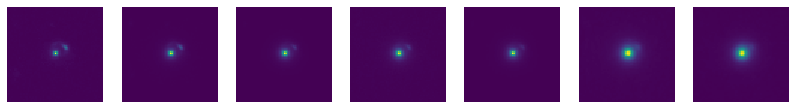

In [15]:
hf = h5py.File('Sample.hdf5', 'r')
hf.keys()

boz=np.random.randint(1,sample_size)
mm = hf['train_img'][boz, ...]
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mm[i,:,:],origin='lower')
    plt.axis('off')
hf.close()

In [18]:
import torch
from galaxy_hdf5loader import galaxydata

dataset = galaxydata('Sample.hdf5')
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True, num_workers=int(0))

inputs, classes = next(iter(dataloader))  
real_cpu = inputs.to('cpu')
ajab = real_cpu.detach()
ajab = ajab.cpu()

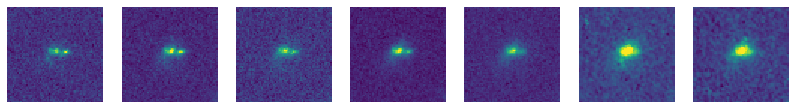

In [19]:
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(ajab[0,i,:,:],origin='lower')
    plt.axis('off')
